In [26]:
%matplotlib inline
import os
import sys
project_dir = os.path.join(os.pardir, os.pardir)
sys.path.append(project_dir)

import dotenv
dotenv_path = os.path.join(project_dir, '.env')
dotenv.load_dotenv(dotenv_path)

import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
from matplotlib import pyplot as plt

import folium

pd.options.display.max_columns = 30

Carregamento de dados de engarrafamentos por trecho de rua em Joinville:

In [19]:
gdf = gpd.read_file(project_dir + "/data/interim/traffic_indicators.geoJSON")

#Lookup to change period for Período
lkp_period = pd.DataFrame({"Período": ["Manha", "Tarde"]}, index=[-1, 1])
gdf = gdf.join(lkp_period, on="period")
gdf.drop("period", axis=1, inplace=True)
cols = gdf.columns.tolist()
gdf = gdf[cols[:4] + [cols[-1]] + cols[4:-1]]

print(gdf.shape)
gdf.drop("geometry", axis=1).head(5)

(6943, 11)


,Codigo do Trecho,Rua,Direcao L/O,Direcao N/S,Período,Probabilidade de Transito,Velocidade Media (km/h),Fila media (m),Atraso medio (s),Nivel medio de congestionamento (0 a 5)
0,8322,FLORIANOPOLIS,East,South,Tarde,0.999399,9.488199,546.922794,154.466912,3.176471
1,13990,FLORIANOPOLIS,East,South,Tarde,0.999399,9.488199,546.922794,154.466912,3.176471
2,5171,FLORIANOPOLIS,East,South,Tarde,0.999260,9.509775,551.101124,155.295880,3.179775
3,11432,NOVE DE MARCO,East,South,Tarde,0.999193,9.152456,582.859649,149.521930,2.986842
4,14047,OTTOKAR DOERFFEL,West,South,Tarde,0.999071,9.762273,1088.242424,313.268939,3.450758


Eliminação das ruas com baixa probabilidade de trânsito

In [20]:
gdf = gdf[gdf["Probabilidade de Transito"]>0.2]
print(gdf.shape)
gdf.head(5)

(2528, 11)


,Codigo do Trecho,Rua,Direcao L/O,Direcao N/S,Período,Probabilidade de Transito,Velocidade Media (km/h),Fila media (m),Atraso medio (s),Nivel medio de congestionamento (0 a 5),geometry
0,8322,FLORIANOPOLIS,East,South,Tarde,0.999399,9.488199,546.922794,154.466912,3.176471,POLYGON ((-48.83822475403328 -26.3228380722825...
1,13990,FLORIANOPOLIS,East,South,Tarde,0.999399,9.488199,546.922794,154.466912,3.176471,POLYGON ((-48.83856901236984 -26.3223585139055...
2,5171,FLORIANOPOLIS,East,South,Tarde,0.999260,9.509775,551.101124,155.295880,3.179775,POLYGON ((-48.83761163183942 -26.3236965472258...
3,11432,NOVE DE MARCO,East,South,Tarde,0.999193,9.152456,582.859649,149.521930,2.986842,POLYGON ((-48.84168784171818 -26.3018900162340...
4,14047,OTTOKAR DOERFFEL,West,South,Tarde,0.999071,9.762273,1088.242424,313.268939,3.450758,POLYGON ((-48.85839700701319 -26.3130386950682...


As 10 ruas mais críticas de Joinville:

In [21]:
gdf.sort_values("Atraso medio (s)", ascending=False).drop_duplicates("Rua").drop("geometry", axis=1).head(10)

,Codigo do Trecho,Rua,Direcao L/O,Direcao N/S,Período,Probabilidade de Transito,Velocidade Media (km/h),Fila media (m),Atraso medio (s),Nivel medio de congestionamento (0 a 5)
2189,14576,GOVERNADOR MARIO COVAS,West,North,Tarde,0.263418,21.042941,16398.000000,2303.176471,3.117647
2130,3530,MONSENHOR GERCINO,East,South,Tarde,0.267427,10.443529,3153.529412,999.000000,3.529412
2051,11313,OTTOKAR DOERFFEL,East,North,Tarde,0.280709,6.183333,1750.444444,942.277778,4.000000
2454,15917,PREFEITO HELMUT FALLGATTER,West,South,Manha,0.209787,12.621052,2949.286285,739.118509,3.383489
1550,1863,MINISTRO CALOGERAS,East,North,Tarde,0.406474,6.256786,1084.642857,608.892857,3.892857
2266,7394,MAX COLIN,West,North,Tarde,0.240849,8.698667,1653.400000,588.066667,3.466667
2215,7570,RIO GRANDE DO SUL,West,North,Tarde,0.255968,8.657500,886.625000,574.062500,3.250000
1614,10623,DONA FRANCISCA,West,North,Manha,0.380854,9.780780,1568.208000,556.680000,3.536667
2436,5176,SAO PAULO,West,North,Manha,0.210813,9.699973,1657.137885,536.737617,3.538153
2244,7400,QUINZE DE NOVEMBRO,East,South,Tarde,0.251009,8.303125,1333.375000,535.500000,3.500000


Categorização dos trechos de Joinville em relação à Probabilidade de Trânsito e Criticidade do Trânsito - Período MATUTINO

Text(0.5,1,'Tarde')

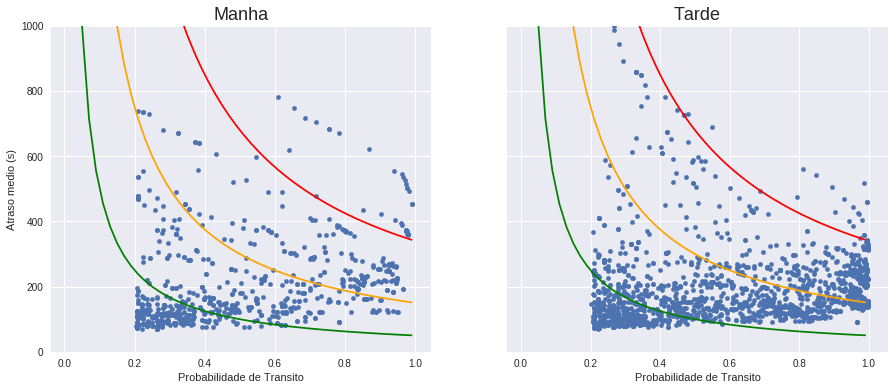

In [38]:
df = gdf.drop("geometry", axis=1)
plt.clf()
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
f.set_figheight(6)
f.set_figwidth(15)


df[df["Período"] == "Manha"].plot("Probabilidade de Transito", "Atraso medio (s)", kind="scatter", ax=ax1)
df[df["Período"] == "Tarde"].plot("Probabilidade de Transito", "Atraso medio (s)", kind="scatter", ax=ax2)

x = np.arange(0.01, 1.0, 0.02)
y = 50/x
ax1.plot(x,y, color="green")
ax2.plot(x,y, color="green")

x = np.arange(0.01, 1.0, 0.02)
y = 150/x
ax1.plot(x,y, color="orange")
ax2.plot(x,y, color="orange")

x = np.arange(0.01, 1.0, 0.02)
y = 340/x
ax1.plot(x,y, color="red")
ax2.plot(x,y, color="red")

ax1.set_ylim([0,1000])
ax1.set_title("Manha", fontsize=18)
ax2.set_title("Tarde", fontsize=18)

In [83]:
gdf_critical = gdf[(gdf["Probabilidade de Transito"]*df["Atraso medio (s)"])>=150]
gdf_critical = gdf_critical[gdf_critical["period"]==1]

print(gdf_critical.shape)
gdf_critical.drop("geometry", axis=1).sort_values("Fila media (m)", ascending=False).head(10)

(511, 11)


,Codigo do Trecho,Rua,Direcao L/O,Direcao N/S,period,Probabilidade de Transito,Velocidade Media (km/h),Fila media (m),Atraso medio (s),Nivel medio de congestionamento (0 a 5)
2188,13389,GOVERNADOR MARIO COVAS,West,North,1,0.263418,21.042941,16398.000000,2303.176471,3.117647
2192,14973,GOVERNADOR MARIO COVAS,West,North,1,0.263418,21.042941,16398.000000,2303.176471,3.117647
2191,14927,GOVERNADOR MARIO COVAS,West,North,1,0.263418,21.042941,16398.000000,2303.176471,3.117647
2190,14925,GOVERNADOR MARIO COVAS,West,North,1,0.263418,21.042941,16398.000000,2303.176471,3.117647
2189,14576,GOVERNADOR MARIO COVAS,West,North,1,0.263418,21.042941,16398.000000,2303.176471,3.117647
2187,9471,GOVERNADOR MARIO COVAS,West,North,1,0.263418,21.042941,16398.000000,2303.176471,3.117647
2104,14975,GOVERNADOR MARIO COVAS,West,North,1,0.276341,23.789444,15830.111111,2180.500000,3.000000
2103,13571,GOVERNADOR MARIO COVAS,West,North,1,0.276341,23.789444,15830.111111,2180.500000,3.000000
2195,14978,GOVERNADOR MARIO COVAS,West,North,1,0.263418,21.520000,15706.352941,2195.588235,3.117647
2194,14928,GOVERNADOR MARIO COVAS,West,North,1,0.263418,21.520000,15706.352941,2195.588235,3.117647


In [84]:
map_osm = folium.Map(location=[-26.30151, -48.84793], zoom_start=12, tiles='Stamen Toner')

folium.GeoJson(gdf_critical[gdf_critical["period"]==1]).add_to(map_osm)
map_osm

